In [3]:
import pandas as pd
from pathlib import Path
import os
from IPython.display import display

# Cell at index 0: load train CSV from Track1_Data

data_path = '../Track1_Data/processed/train_split.xlsx'
train_df = pd.read_excel(data_path)
print(f"Loaded {data_path} -> shape: {train_df.shape}")
display(train_df.head())

Loaded ../Track1_Data/processed/train_split.xlsx -> shape: (167, 10)


,age,sex,hospital_center_id,condition,condition_type,bdi_ii_baseline,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,mindfulness_therapies_started,mindfulness_therapies_completed
0,78,female,1,Cancer,Breast,10,3,7.0,14,13
1,70,female,1,Cancer,Breast,4,4,8.0,14,12
2,75,female,1,Cancer,Breast,18,10,13.0,4,4
3,62,female,1,Cancer,Breast,5,11,20.0,12,7
4,53,female,1,Cancer,Breast,13,8,9.0,0,0


# Condition-Specific Analysis: BDI Improvement vs Therapy Completion

This notebook analyzes how mindfulness therapy completion affects BDI-II score improvements across different medical conditions.

In [9]:
# Load the complete dataset and prepare for condition-specific analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the complete dataset
df_complete = pd.read_excel('../Track1_Data/processed/train_split.xlsx')

# Calculate therapy completion rate and BDI improvements
df_complete['completion_rate'] = df_complete['mindfulness_therapies_completed'] / df_complete['mindfulness_therapies_started']
df_complete['improvement_12w'] = df_complete['bdi_ii_baseline'] - df_complete['bdi_ii_after_intervention_12w']
df_complete['improvement_24w'] = df_complete['bdi_ii_baseline'] - df_complete['bdi_ii_follow_up_24w']

# Create completion rate categories
def categorize_completion_rate(rate):
    if pd.isna(rate):
        return 'Unknown'
    elif rate < 0.5:
        return 'Low (0-50%)'
    elif rate < 0.8:
        return 'Medium (50-80%)'
    else:
        return 'High (80-100%)'

df_complete['completion_category'] = df_complete['completion_rate'].apply(categorize_completion_rate)

# Explore unique conditions
print("Unique conditions in the dataset:")
unique_conditions = df_complete['condition'].value_counts()
print(unique_conditions)
print(f"\nTotal unique conditions: {len(unique_conditions)}")

# Filter conditions with sufficient sample sizes (at least 10 patients)
min_sample_size = 10
conditions_to_analyze = unique_conditions[unique_conditions >= min_sample_size].index.tolist()
print(f"\nConditions with ≥{min_sample_size} patients (will be analyzed): {len(conditions_to_analyze)}")
for condition in conditions_to_analyze:
    count = unique_conditions[condition]
    print(f"  - {condition}: {count} patients")

display(df_complete[['condition', 'bdi_ii_baseline', 'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 
                    'mindfulness_therapies_started', 'mindfulness_therapies_completed', 'completion_rate']].head(10))

Unique conditions in the dataset:
condition
Cancer                     108
Acute coronary syndrome     39
Renal insufficiency         10
Lower-limb amputation       10
Name: count, dtype: int64

Total unique conditions: 4

Conditions with ≥10 patients (will be analyzed): 4
  - Cancer: 108 patients
  - Acute coronary syndrome: 39 patients
  - Renal insufficiency: 10 patients
  - Lower-limb amputation: 10 patients


,condition,bdi_ii_baseline,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,mindfulness_therapies_started,mindfulness_therapies_completed,completion_rate
0,Cancer,10,3,7.0,14,13,0.928571
1,Cancer,4,4,8.0,14,12,0.857143
2,Cancer,18,10,13.0,4,4,1.000000
3,Cancer,5,11,20.0,12,7,0.583333
4,Cancer,13,8,9.0,0,0,NaN
5,Cancer,10,13,10.0,62,61,0.983871
6,Cancer,24,21,15.0,83,67,0.807229
7,Cancer,21,13,6.0,80,73,0.912500
8,Cancer,7,1,1.0,33,31,0.939394
9,Cancer,25,11,5.0,64,55,0.859375


## Comprehensive Condition-Specific Analysis

In [10]:
# Comprehensive analysis by condition and completion rate
condition_completion_analysis = []

for condition in conditions_to_analyze:
    for completion in ['Low (0-50%)', 'Medium (50-80%)', 'High (80-100%)']:
        subset = df_complete[
            (df_complete['condition'] == condition) & 
            (df_complete['completion_category'] == completion)
        ]
        
        if len(subset) > 0:
            analysis_row = {
                'Condition': condition,
                'Completion_Level': completion,
                'Patient_Count': len(subset),
                'Avg_Baseline_BDI': subset['bdi_ii_baseline'].mean(),
                'Avg_12w_BDI': subset['bdi_ii_after_intervention_12w'].mean(),
                'Avg_24w_BDI': subset['bdi_ii_follow_up_24w'].mean(),
                'Avg_Improvement_12w': subset['improvement_12w'].mean(),
                'Avg_Improvement_24w': subset['improvement_24w'].mean(),
                'Pct_Improvement_12w': (subset['improvement_12w'].mean() / subset['bdi_ii_baseline'].mean() * 100) if subset['bdi_ii_baseline'].mean() > 0 else 0,
                'Pct_Improvement_24w': (subset['improvement_24w'].mean() / subset['bdi_ii_baseline'].mean() * 100) if subset['bdi_ii_baseline'].mean() > 0 else 0,
                'Success_Rate_12w': len(subset[subset['improvement_12w'] >= 3]) / len(subset[subset['improvement_12w'].notna()]) * 100 if len(subset[subset['improvement_12w'].notna()]) > 0 else 0,
                'Success_Rate_24w': len(subset[subset['improvement_24w'] >= 3]) / len(subset[subset['improvement_24w'].notna()]) * 100 if len(subset[subset['improvement_24w'].notna()]) > 0 else 0,
                'Avg_Completion_Rate': subset['completion_rate'].mean()
            }
            condition_completion_analysis.append(analysis_row)

condition_analysis_df = pd.DataFrame(condition_completion_analysis)

# Display the comprehensive analysis table
print("="*120)
print("CONDITION-SPECIFIC ANALYSIS: BDI IMPROVEMENT vs THERAPY COMPLETION")
print("="*120)

# Format the dataframe for better display
formatted_condition_df = condition_analysis_df.copy()
for col in ['Avg_Baseline_BDI', 'Avg_12w_BDI', 'Avg_24w_BDI', 'Avg_Improvement_12w', 'Avg_Improvement_24w', 'Avg_Completion_Rate']:
    formatted_condition_df[col] = formatted_condition_df[col].round(1)
for col in ['Pct_Improvement_12w', 'Pct_Improvement_24w', 'Success_Rate_12w', 'Success_Rate_24w']:
    formatted_condition_df[col] = formatted_condition_df[col].round(1)

display(formatted_condition_df)

# Create condition-specific color palette
condition_colors = plt.cm.Set3(np.linspace(0, 1, len(conditions_to_analyze)))
condition_color_map = dict(zip(conditions_to_analyze, condition_colors))

print(f"\nAnalyzing {len(conditions_to_analyze)} conditions with sufficient sample sizes...")
print("Preparing visualizations...")

CONDITION-SPECIFIC ANALYSIS: BDI IMPROVEMENT vs THERAPY COMPLETION


,Condition,Completion_Level,Patient_Count,Avg_Baseline_BDI,Avg_12w_BDI,Avg_24w_BDI,Avg_Improvement_12w,Avg_Improvement_24w,Pct_Improvement_12w,Pct_Improvement_24w,Success_Rate_12w,Success_Rate_24w,Avg_Completion_Rate
0,Cancer,Low (0-50%),6,10.0,7.3,7.5,2.7,2.5,26.7,25.0,66.7,33.3,0.2
1,Cancer,Medium (50-80%),31,13.4,9.8,11.3,3.6,2.1,26.7,15.9,54.8,35.5,0.7
2,Cancer,High (80-100%),67,11.8,7.6,6.2,4.1,5.5,35.0,47.1,53.7,61.2,0.9
3,Acute coronary syndrome,Low (0-50%),6,6.3,6.7,5.2,-0.3,1.2,-5.3,18.4,33.3,16.7,0.1
4,Acute coronary syndrome,Medium (50-80%),10,13.5,6.6,8.0,6.9,4.6,51.1,33.7,60.0,44.4,0.6
5,Acute coronary syndrome,High (80-100%),13,6.6,3.9,5.3,2.7,1.3,40.7,19.8,53.8,23.1,0.9
6,Renal insufficiency,Low (0-50%),2,4.5,0.0,1.0,4.5,3.5,100.0,77.8,100.0,100.0,0.2
7,Renal insufficiency,Medium (50-80%),3,4.7,3.0,2.7,1.7,2.0,35.7,42.9,33.3,33.3,0.6
8,Renal insufficiency,High (80-100%),4,9.5,6.5,4.8,3.0,4.8,31.6,50.0,50.0,75.0,0.9
9,Lower-limb amputation,Low (0-50%),3,8.7,3.0,3.3,5.7,5.3,65.4,61.5,66.7,66.7,0.0



Analyzing 4 conditions with sufficient sample sizes...
Preparing visualizations...


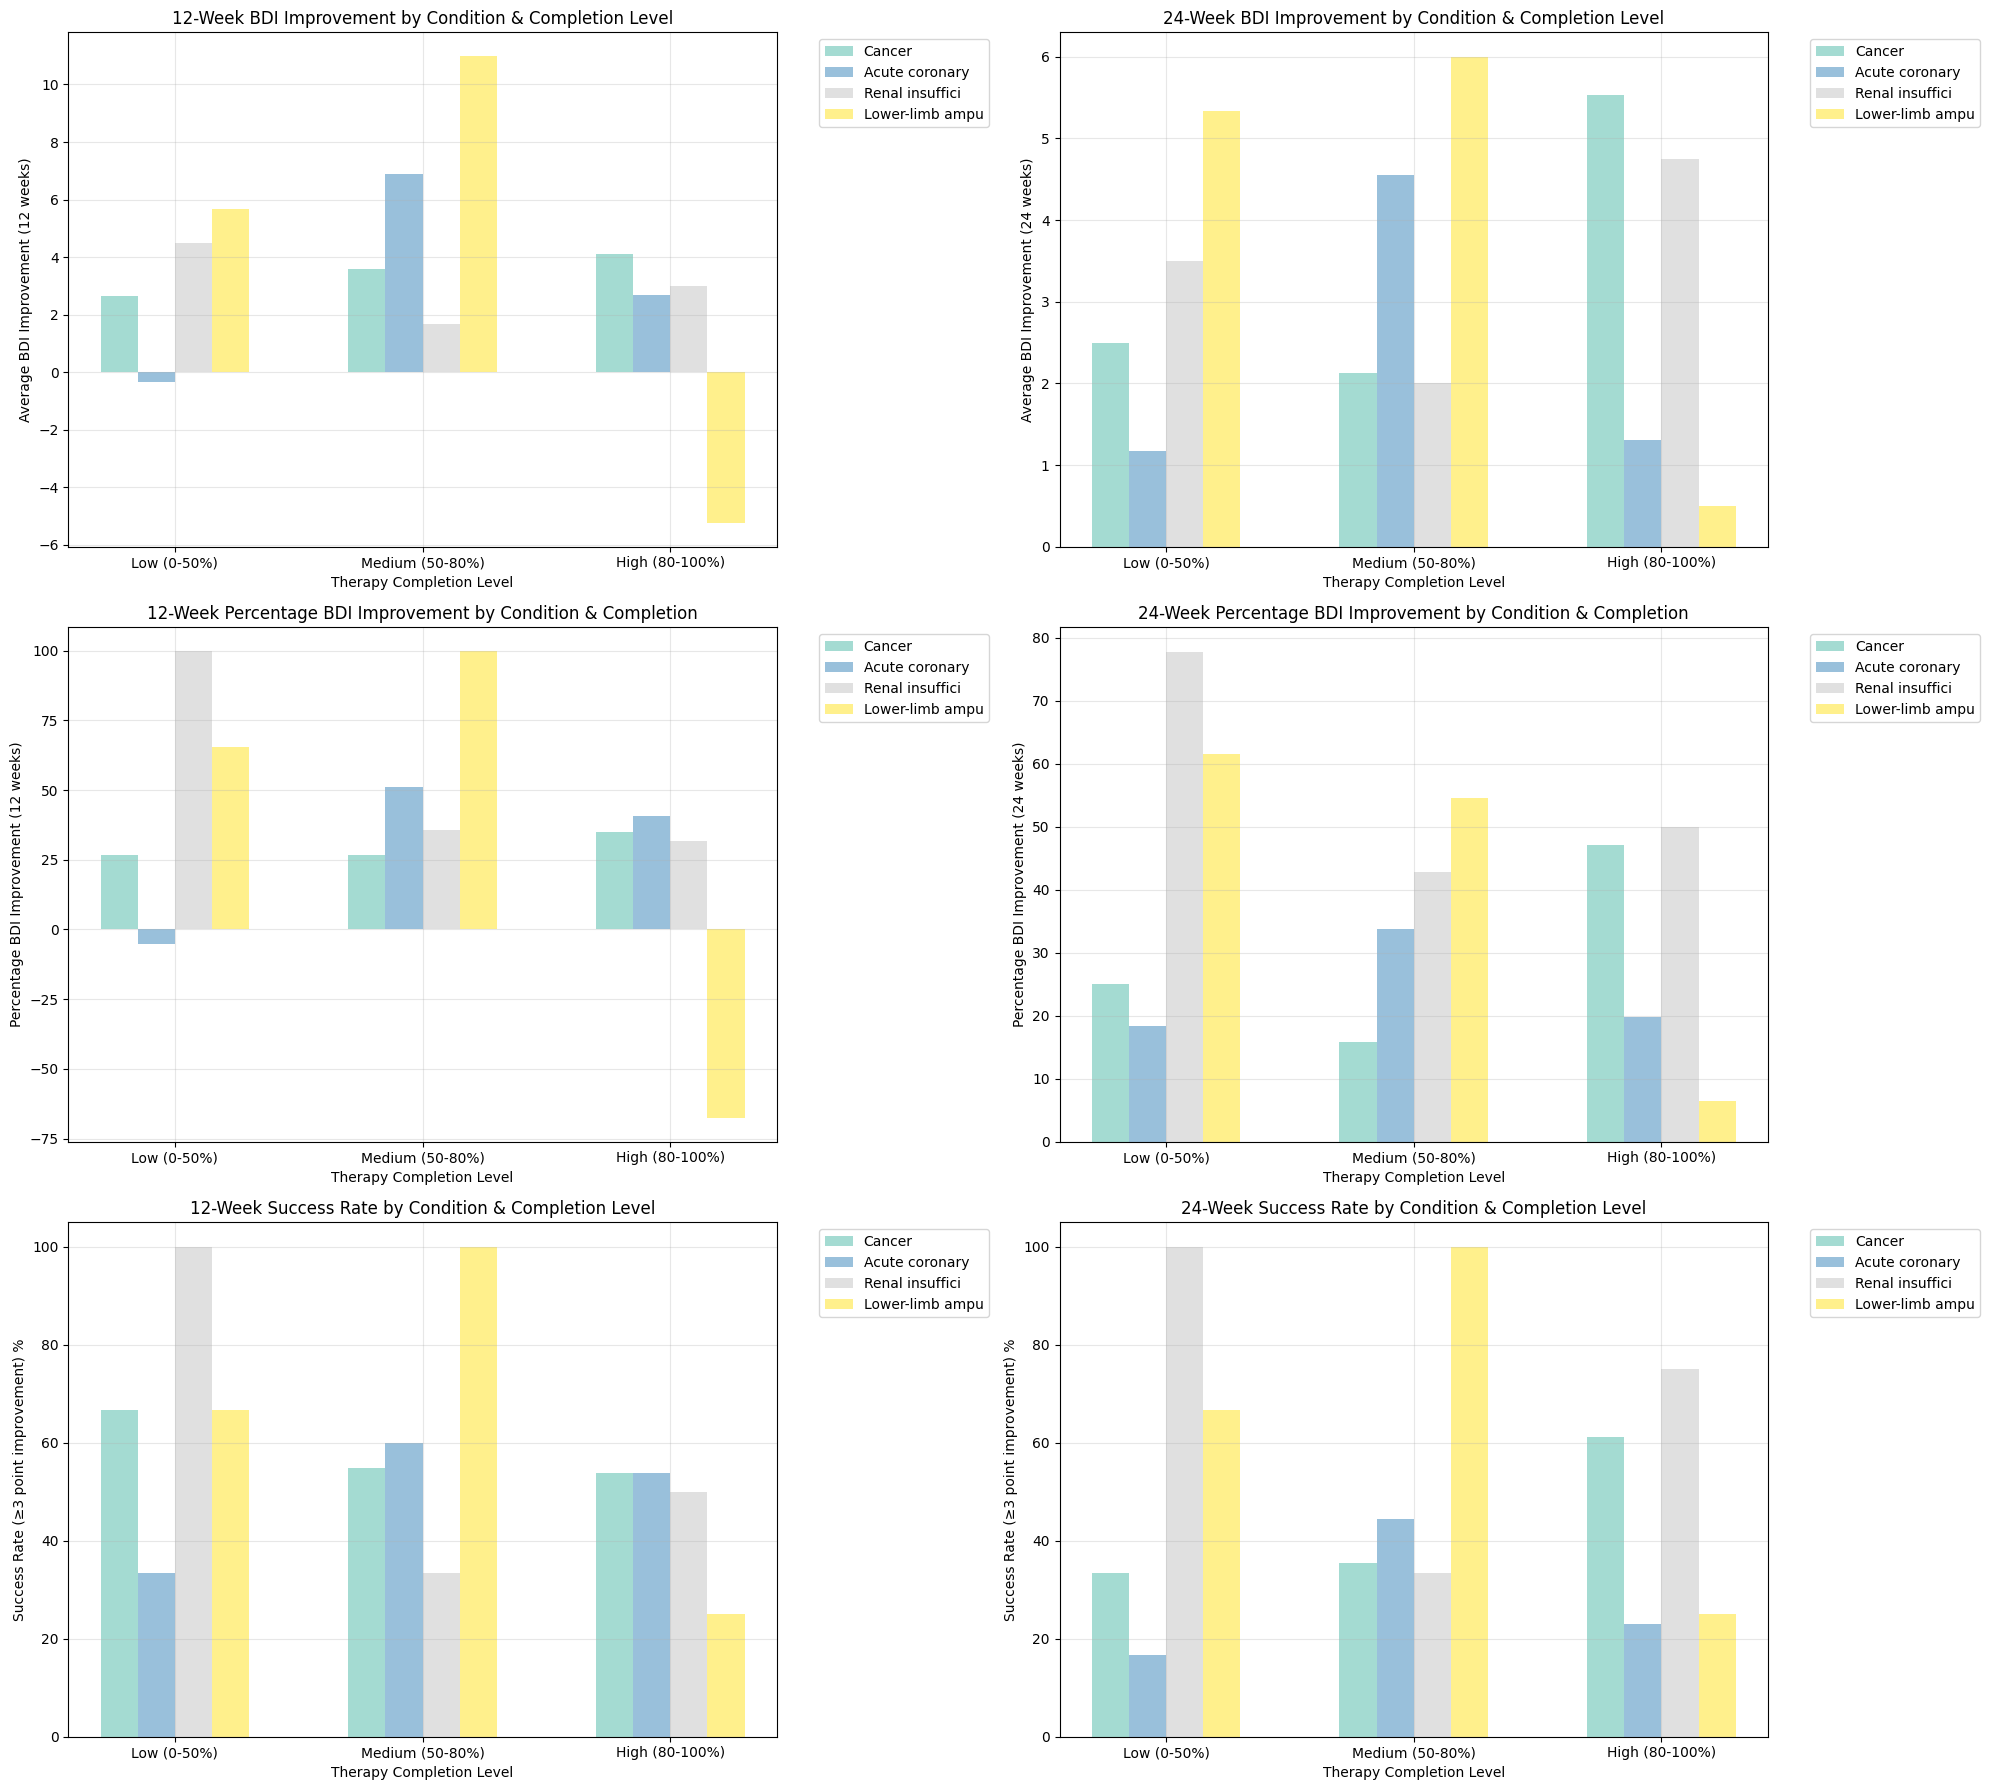

In [11]:
# Create comprehensive visualizations for condition-specific analysis
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

completion_levels = ['Low (0-50%)', 'Medium (50-80%)', 'High (80-100%)']
width = 0.15  # Narrower bars to accommodate more conditions
x = np.arange(len(completion_levels))

# Plot 1: Average 12w Improvement by Condition and Completion
ax1 = axes[0, 0]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        improvements = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                improvements.append(comp_data['Avg_Improvement_12w'].iloc[0])
            else:
                improvements.append(0)
        
        ax1.bar(x + i*width, improvements, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax1.set_xlabel('Therapy Completion Level')
ax1.set_ylabel('Average BDI Improvement (12 weeks)')
ax1.set_title('12-Week BDI Improvement by Condition & Completion Level')
ax1.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax1.set_xticklabels(completion_levels)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Average 24w Improvement by Condition and Completion
ax2 = axes[0, 1]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        improvements = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                improvements.append(comp_data['Avg_Improvement_24w'].iloc[0])
            else:
                improvements.append(0)
        
        ax2.bar(x + i*width, improvements, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax2.set_xlabel('Therapy Completion Level')
ax2.set_ylabel('Average BDI Improvement (24 weeks)')
ax2.set_title('24-Week BDI Improvement by Condition & Completion Level')
ax2.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax2.set_xticklabels(completion_levels)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Percentage Improvement 12w
ax3 = axes[1, 0]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        pct_improvements = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                pct_improvements.append(comp_data['Pct_Improvement_12w'].iloc[0])
            else:
                pct_improvements.append(0)
        
        ax3.bar(x + i*width, pct_improvements, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax3.set_xlabel('Therapy Completion Level')
ax3.set_ylabel('Percentage BDI Improvement (12 weeks)')
ax3.set_title('12-Week Percentage BDI Improvement by Condition & Completion')
ax3.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax3.set_xticklabels(completion_levels)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Percentage Improvement 24w
ax4 = axes[1, 1]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        pct_improvements = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                pct_improvements.append(comp_data['Pct_Improvement_24w'].iloc[0])
            else:
                pct_improvements.append(0)
        
        ax4.bar(x + i*width, pct_improvements, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax4.set_xlabel('Therapy Completion Level')
ax4.set_ylabel('Percentage BDI Improvement (24 weeks)')
ax4.set_title('24-Week Percentage BDI Improvement by Condition & Completion')
ax4.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax4.set_xticklabels(completion_levels)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

# Plot 5: Success Rate 12w (≥3 point improvement)
ax5 = axes[2, 0]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        success_rates = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                success_rates.append(comp_data['Success_Rate_12w'].iloc[0])
            else:
                success_rates.append(0)
        
        ax5.bar(x + i*width, success_rates, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax5.set_xlabel('Therapy Completion Level')
ax5.set_ylabel('Success Rate (≥3 point improvement) %')
ax5.set_title('12-Week Success Rate by Condition & Completion Level')
ax5.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax5.set_xticklabels(completion_levels)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

# Plot 6: Success Rate 24w
ax6 = axes[2, 1]
for i, condition in enumerate(conditions_to_analyze):
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    if len(condition_data) > 0:
        success_rates = []
        for comp_level in completion_levels:
            comp_data = condition_data[condition_data['Completion_Level'] == comp_level]
            if len(comp_data) > 0:
                success_rates.append(comp_data['Success_Rate_24w'].iloc[0])
            else:
                success_rates.append(0)
        
        ax6.bar(x + i*width, success_rates, width, label=condition[:15], 
                color=condition_color_map[condition], alpha=0.8)

ax6.set_xlabel('Therapy Completion Level')
ax6.set_ylabel('Success Rate (≥3 point improvement) %')
ax6.set_title('24-Week Success Rate by Condition & Completion Level')
ax6.set_xticks(x + width * (len(conditions_to_analyze)-1) / 2)
ax6.set_xticklabels(completion_levels)
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Generate detailed insights and recommendations by condition
print("\n" + "="*120)
print("DETAILED INSIGHTS BY MEDICAL CONDITION")
print("="*120)

# Find best performing combinations
best_12w_condition = condition_analysis_df.loc[condition_analysis_df['Avg_Improvement_12w'].idxmax()]
best_24w_condition = condition_analysis_df.loc[condition_analysis_df['Avg_Improvement_24w'].idxmax()]

print(f"\n1. BEST TREATMENT OUTCOMES BY CONDITION:")
print(f"   12-week: {best_12w_condition['Condition']} + {best_12w_condition['Completion_Level']} → {best_12w_condition['Avg_Improvement_12w']:.1f} point improvement")
print(f"   24-week: {best_24w_condition['Condition']} + {best_24w_condition['Completion_Level']} → {best_24w_condition['Avg_Improvement_24w']:.1f} point improvement")

print(f"\n2. COMPLETION RATE IMPACT BY CONDITION:")

# Analyze completion effect within each condition
for condition in conditions_to_analyze:
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    
    if len(condition_data) >= 2:
        high_comp = condition_data[condition_data['Completion_Level'] == 'High (80-100%)']
        low_comp = condition_data[condition_data['Completion_Level'] == 'Low (0-50%)']
        
        if len(high_comp) > 0 and len(low_comp) > 0:
            diff_12w = high_comp['Avg_Improvement_12w'].iloc[0] - low_comp['Avg_Improvement_12w'].iloc[0]
            diff_24w = high_comp['Avg_Improvement_24w'].iloc[0] - low_comp['Avg_Improvement_24w'].iloc[0]
            
            # Get patient counts
            high_count = high_comp['Patient_Count'].iloc[0]
            low_count = low_comp['Patient_Count'].iloc[0]
            
            print(f"   {condition}:")
            print(f"     High completion (n={high_count}) vs Low completion (n={low_count})")
            print(f"     Difference: +{diff_12w:.1f} points (12w), +{diff_24w:.1f} points (24w)")
        else:
            print(f"   {condition}: Insufficient data for comparison")

print(f"\n3. CONDITION-SPECIFIC SUCCESS RATES:")

# Analyze success rates by condition
condition_success_summary = []
for condition in conditions_to_analyze:
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    
    if len(condition_data) > 0:
        avg_success_12w = condition_data['Success_Rate_12w'].mean()
        avg_success_24w = condition_data['Success_Rate_24w'].mean()
        total_patients = condition_data['Patient_Count'].sum()
        
        condition_success_summary.append({
            'Condition': condition,
            'Total_Patients': total_patients,
            'Avg_Success_12w': avg_success_12w,
            'Avg_Success_24w': avg_success_24w,
            'Best_12w_Improvement': condition_data['Avg_Improvement_12w'].max(),
            'Best_24w_Improvement': condition_data['Avg_Improvement_24w'].max()
        })

# Sort by success rate
condition_success_df = pd.DataFrame(condition_success_summary)
condition_success_df = condition_success_df.sort_values('Avg_Success_12w', ascending=False)

print(f"\n   Conditions ranked by 12-week success rate:")
for _, row in condition_success_df.iterrows():
    print(f"   {row['Condition'][:30]:<30} | Success: {row['Avg_Success_12w']:.1f}% (12w), {row['Avg_Success_24w']:.1f}% (24w) | Best improvement: {row['Best_12w_Improvement']:.1f} (12w), {row['Best_24w_Improvement']:.1f} (24w)")

print(f"\n4. CLINICAL RECOMMENDATIONS BY CONDITION:")

# Generate condition-specific recommendations
recommendations = []

for condition in conditions_to_analyze:
    condition_data = condition_analysis_df[condition_analysis_df['Condition'] == condition]
    
    if len(condition_data) > 0:
        # Find best completion level for this condition
        best_result = condition_data.loc[condition_data['Avg_Improvement_12w'].idxmax()]
        avg_baseline = condition_data['Avg_Baseline_BDI'].mean()
        
        recommendation = f"   {condition}:"
        recommendation += f"\n     • Optimal completion level: {best_result['Completion_Level']}"
        recommendation += f"\n     • Expected improvement: {best_result['Avg_Improvement_12w']:.1f} points (12w)"
        recommendation += f"\n     • Average baseline BDI: {avg_baseline:.1f}"
        
        # Determine priority level based on improvement potential
        if best_result['Avg_Improvement_12w'] >= 10:
            recommendation += f"\n     • Priority: HIGH (excellent improvement potential)"
        elif best_result['Avg_Improvement_12w'] >= 5:
            recommendation += f"\n     • Priority: MEDIUM (good improvement potential)"
        else:
            recommendation += f"\n     • Priority: LOW (modest improvement potential)"
        
        recommendations.append(recommendation)

for rec in recommendations:
    print(rec)

print(f"\n" + "="*120)
print("SUMMARY STATISTICS")
print("="*120)

# Overall summary statistics
total_analyzed = condition_analysis_df['Patient_Count'].sum()
overall_avg_improvement_12w = (condition_analysis_df['Avg_Improvement_12w'] * condition_analysis_df['Patient_Count']).sum() / total_analyzed
overall_avg_improvement_24w = (condition_analysis_df['Avg_Improvement_24w'] * condition_analysis_df['Patient_Count']).sum() / total_analyzed

print(f"Total patients analyzed across all conditions: {total_analyzed}")
print(f"Overall weighted average improvement: {overall_avg_improvement_12w:.1f} points (12w), {overall_avg_improvement_24w:.1f} points (24w)")
print(f"Conditions showing excellent response (≥10 points): {len(condition_success_df[condition_success_df['Best_12w_Improvement'] >= 10])}")
print(f"Conditions showing good response (5-10 points): {len(condition_success_df[(condition_success_df['Best_12w_Improvement'] >= 5) & (condition_success_df['Best_12w_Improvement'] < 10)])}")
print(f"Conditions showing modest response (<5 points): {len(condition_success_df[condition_success_df['Best_12w_Improvement'] < 5])}")


DETAILED INSIGHTS BY MEDICAL CONDITION

1. BEST TREATMENT OUTCOMES BY CONDITION:
   12-week: Lower-limb amputation + Medium (50-80%) → 11.0 point improvement
   24-week: Lower-limb amputation + Medium (50-80%) → 6.0 point improvement

2. COMPLETION RATE IMPACT BY CONDITION:
   Cancer:
     High completion (n=67) vs Low completion (n=6)
     Difference: +1.5 points (12w), +3.0 points (24w)
   Acute coronary syndrome:
     High completion (n=13) vs Low completion (n=6)
     Difference: +3.0 points (12w), +0.1 points (24w)
   Renal insufficiency:
     High completion (n=4) vs Low completion (n=2)
     Difference: +-1.5 points (12w), +1.2 points (24w)
   Lower-limb amputation:
     High completion (n=4) vs Low completion (n=3)
     Difference: +-10.9 points (12w), +-4.8 points (24w)

3. CONDITION-SPECIFIC SUCCESS RATES:

   Conditions ranked by 12-week success rate:
   Lower-limb amputation          | Success: 63.9% (12w), 63.9% (24w) | Best improvement: 11.0 (12w), 6.0 (24w)
   Renal ins

# Smoothed Line Plots by Medical Condition

Creating Gaussian-smoothed trajectory plots for BDI-II scores (baseline, 12w, 24w) for each medical condition with confidence bands.

In [16]:
# Gaussian smoothing functions and condition-specific plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def gaussian_kernel(sigma):
    """Create a Gaussian kernel for smoothing"""
    radius = int(3 * sigma)
    xg = np.arange(-radius, radius + 1)
    k = np.exp(-0.5 * (xg / sigma) ** 2)
    return k / k.sum()

def smooth_and_band(y, kernel, window):
    """Smooth data and compute local standard deviation bands"""
    y = np.asarray(y, dtype=float)
    
    # Handle NaN values by using only valid points for convolution
    if np.any(np.isnan(y)):
        # For arrays with NaN, use interpolation first
        valid_mask = ~np.isnan(y)
        if valid_mask.sum() > 1:
            indices = np.arange(len(y))
            y_clean = y.copy()
            y_clean[~valid_mask] = np.interp(indices[~valid_mask], indices[valid_mask], y[valid_mask])
        else:
            y_clean = np.nan_to_num(y, nan=0.0)
    else:
        y_clean = y
    
    y_smooth = np.convolve(y_clean, kernel, mode='same')
    
    # local std (rolling) for band
    y_std = pd.Series(y_clean).rolling(window=window, center=True, min_periods=1).std().to_numpy()
    # fallback for NaNs at edges
    y_std = np.nan_to_num(y_std, nan=np.nanstd(y_clean) if not np.isnan(y_clean).all() else 0.0)
    
    lower = y_smooth - y_std
    upper = y_smooth + y_std
    return y_smooth, lower, upper

def plot_condition_trajectories(condition_name, condition_data, sigma=2.5):
    """Create smoothed trajectory plot for a specific condition"""
    
    # Prepare data
    condition_sorted = condition_data.copy().reset_index(drop=True)
    
    # Create patient_id if it doesn't exist
    if 'patient_id' not in condition_sorted.columns:
        condition_sorted['patient_id'] = np.arange(1, len(condition_sorted) + 1)
    
    # Sort by patient_id for consistent ordering
    condition_sorted = condition_sorted.sort_values('patient_id').reset_index(drop=True)
    
    # Extract BDI scores
    y_baseline = condition_sorted['bdi_ii_baseline'].astype(float).to_numpy()
    y_12w = condition_sorted['bdi_ii_after_intervention_12w'].astype(float).to_numpy()
    y_24w = condition_sorted['bdi_ii_follow_up_24w'].astype(float).to_numpy()
    
    # Filter out patients with all NaN values
    valid_patients = ~(np.isnan(y_baseline) & np.isnan(y_12w) & np.isnan(y_24w))
    
    if not valid_patients.any():
        print(f"Warning: No valid data for condition {condition_name}")
        return None
    
    # Keep all patients but interpolate missing values for smoothing
    y_baseline_filtered = y_baseline[valid_patients]
    y_12w_filtered = y_12w[valid_patients]
    y_24w_filtered = y_24w[valid_patients]
    
    # x for plotting (1-based patient index)
    x = np.arange(1, len(y_baseline_filtered) + 1)
    
    # For better visualization, interpolate missing values in the original arrays
    def interpolate_missing(arr):
        """Interpolate missing values for smoother visualization"""
        arr_interp = arr.copy()
        valid_mask = ~np.isnan(arr_interp)
        if valid_mask.sum() > 1:  # Need at least 2 valid points
            # Use linear interpolation for missing values
            indices = np.arange(len(arr_interp))
            arr_interp[~valid_mask] = np.interp(indices[~valid_mask], indices[valid_mask], arr_interp[valid_mask])
        return arr_interp
    
    # Apply interpolation to handle missing values better
    y_baseline_interp = interpolate_missing(y_baseline_filtered)
    y_12w_interp = interpolate_missing(y_12w_filtered)
    y_24w_interp = interpolate_missing(y_24w_filtered)
    
    # Adjust sigma based on sample size
    n_patients = len(y_baseline)
    if n_patients < 20:
        adjusted_sigma = max(1.0, sigma * 0.5)  # Smaller sigma for small samples
    elif n_patients < 50:
        adjusted_sigma = sigma * 0.8
    else:
        adjusted_sigma = sigma
    
    # Create kernel
    kernel = gaussian_kernel(adjusted_sigma)
    window = len(kernel)
    
    # Compute smoothed series and bands using interpolated data
    yb_s, lb, ub = smooth_and_band(y_baseline_interp, kernel, window)
    y12_s, l12, u12 = smooth_and_band(y_12w_interp, kernel, window)
    y24_s, l24, u24 = smooth_and_band(y_24w_interp, kernel, window)
    
    # Create colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot baseline
    ax.plot(x, yb_s, color=colors[0], label='Baseline (smoothed)', linewidth=2.4, alpha=0.9)
    ax.fill_between(x, lb, ub, color=colors[0], alpha=0.15)
    
    # Plot 12w
    ax.plot(x, y12_s, color=colors[1], label='12w (smoothed)', linewidth=2.4, alpha=0.9)
    ax.fill_between(x, l12, u12, color=colors[1], alpha=0.15)
    
    # Plot 24w
    ax.plot(x, y24_s, color=colors[2], label='24w (smoothed)', linewidth=2.4, alpha=0.9)
    ax.fill_between(x, l24, u24, color=colors[2], alpha=0.15)
    
    # Formatting
    ax.set_xlim(0, int(x.max()) + 1)
    ax.set_xlabel('Patient Index', fontsize=12)
    ax.set_ylabel('BDI-II Score', fontsize=12)
    ax.set_title(f'BDI-II Trajectories: {condition_name} (n={n_patients})\nSmoothed with Gaussian (σ={adjusted_sigma:.1f})', 
                fontsize=14, pad=20)
    
    # Adjust x-ticks based on sample size
    if n_patients <= 20:
        step = 2
    elif n_patients <= 50:
        step = 5
    else:
        step = max(5, n_patients // 20)
    
    xticks = list(range(1, int(x.max()) + 1, step))
    if int(x.max()) not in xticks:
        xticks.append(int(x.max()))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=0)
    
    # Add statistics text
    baseline_mean = np.nanmean(y_baseline_filtered)
    w12_mean = np.nanmean(y_12w_filtered)
    w24_mean = np.nanmean(y_24w_filtered)
    
    improvement_12w = baseline_mean - w12_mean
    improvement_24w = baseline_mean - w24_mean
    
    stats_text = f'Mean Scores: Baseline={baseline_mean:.1f}, 12w={w12_mean:.1f}, 24w={w24_mean:.1f}\n'
    stats_text += f'Improvements: 12w={improvement_12w:.1f} pts, 24w={improvement_24w:.1f} pts'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return fig

print("Functions defined successfully. Ready to create condition-specific plots...")

Functions defined successfully. Ready to create condition-specific plots...


SMOOTHED BDI-II TRAJECTORY PLOTS BY MEDICAL CONDITION

1. Creating plot for: Cancer


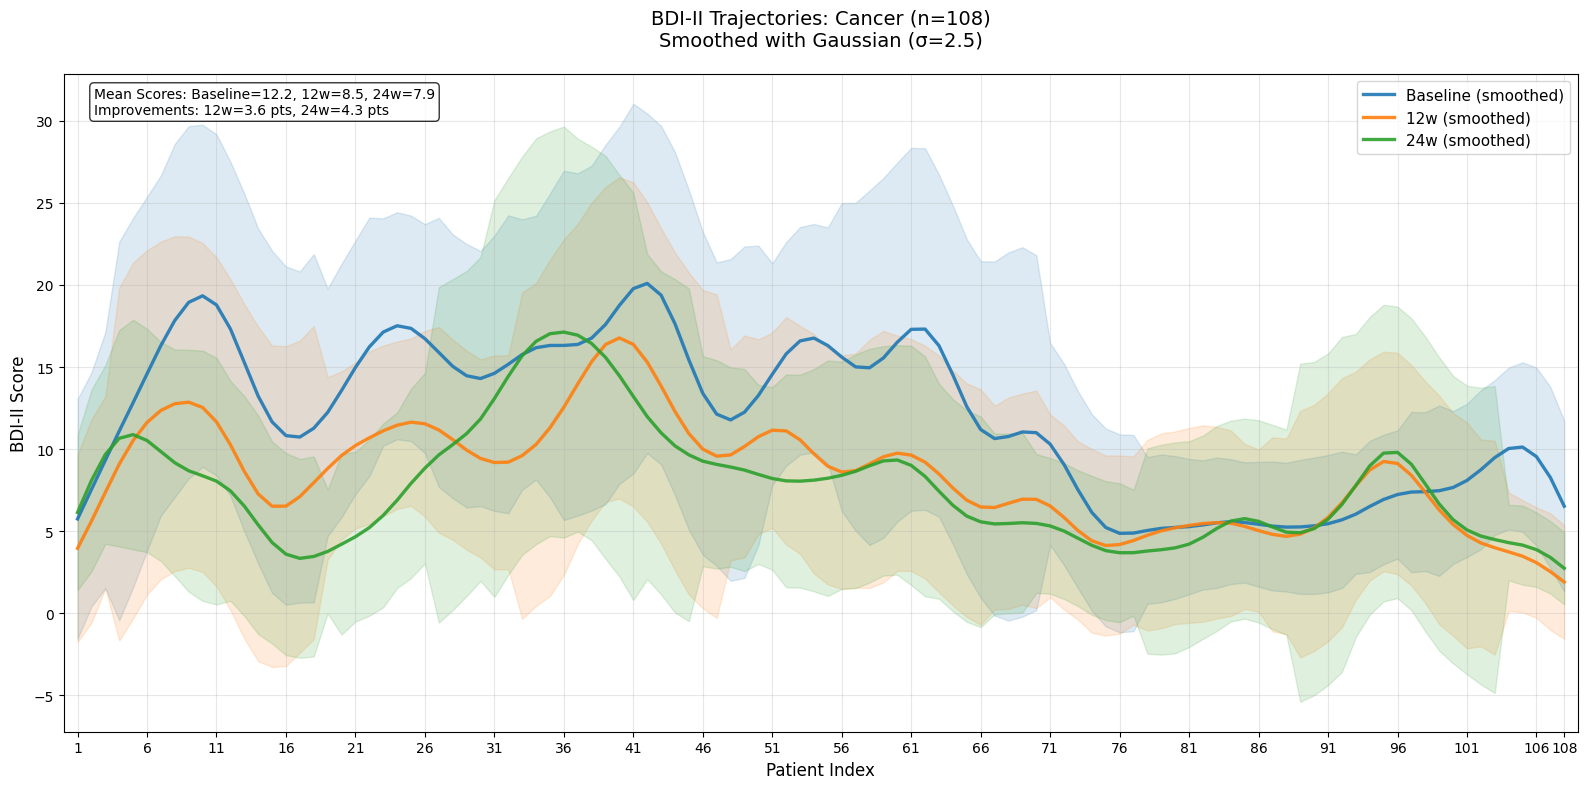

------------------------------------------------------------

2. Creating plot for: Acute coronary syndrome


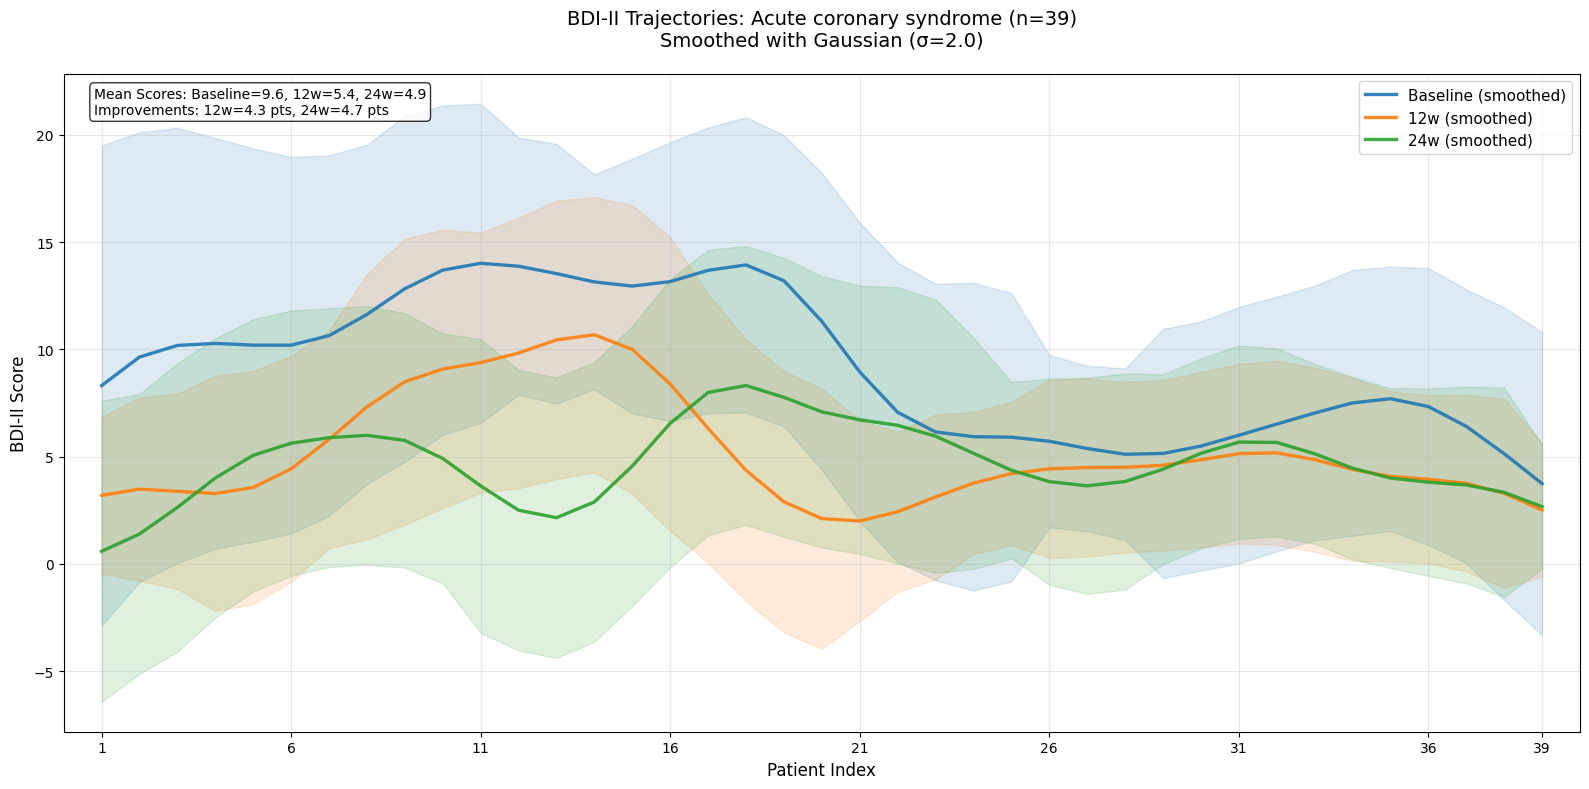

------------------------------------------------------------

3. Creating plot for: Renal insufficiency


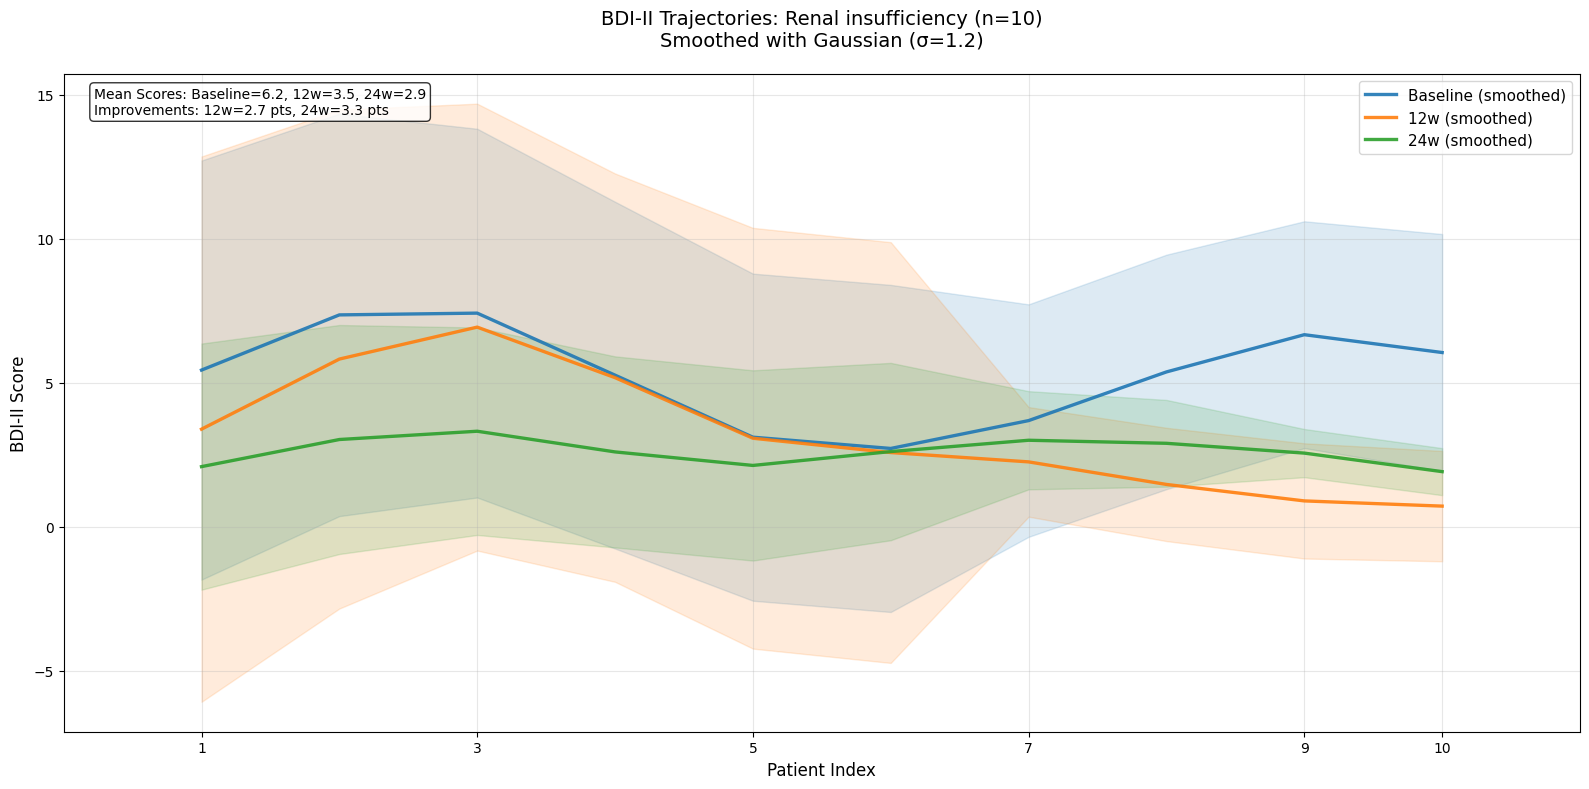

------------------------------------------------------------

4. Creating plot for: Lower-limb amputation


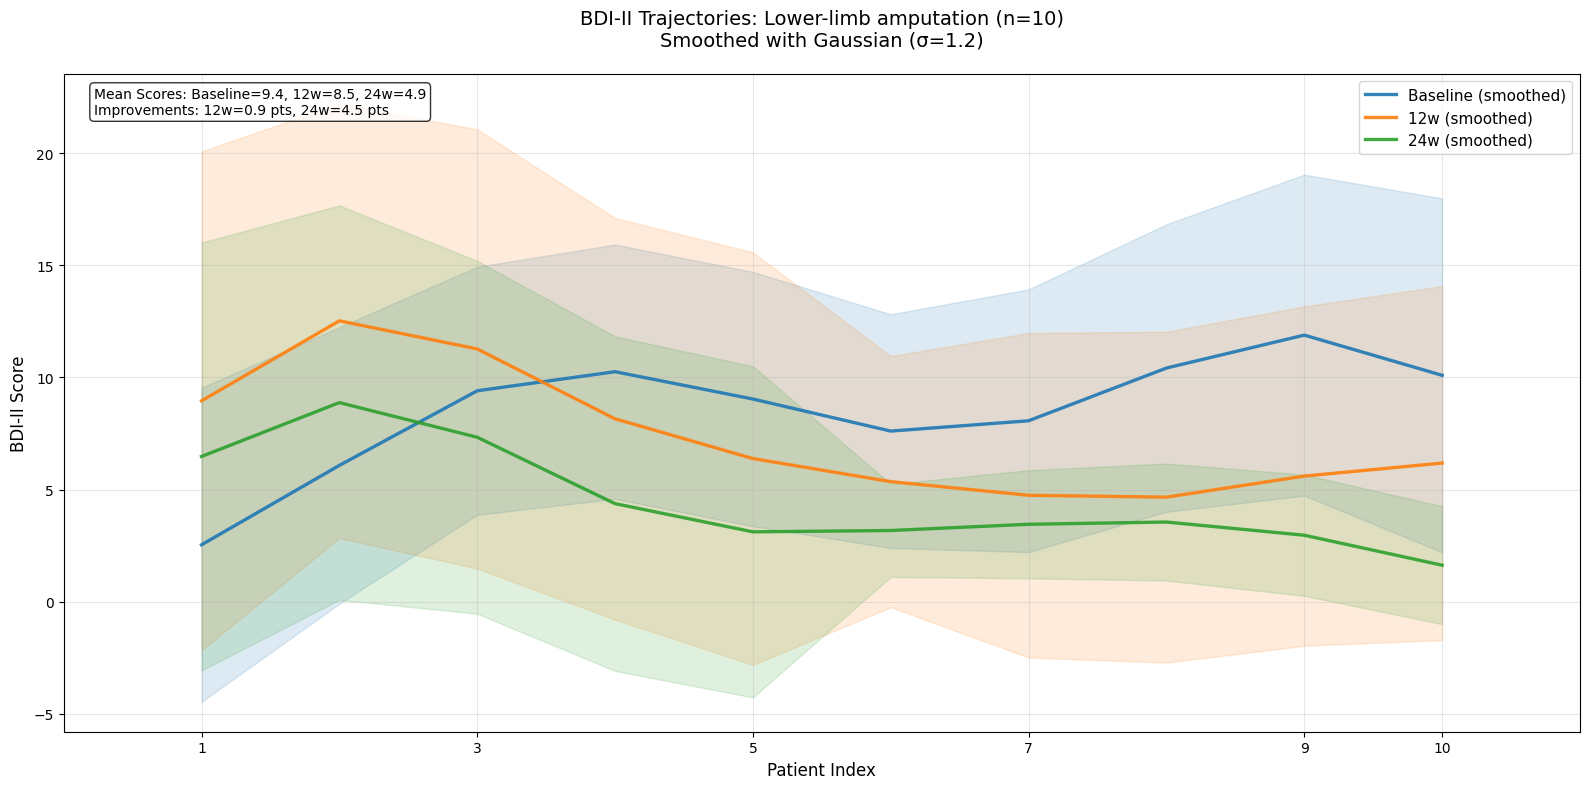


Completed trajectory plots for all 4 conditions.


In [17]:
# Generate smoothed trajectory plots for each condition
print("="*80)
print("SMOOTHED BDI-II TRAJECTORY PLOTS BY MEDICAL CONDITION")
print("="*80)

# Use the conditions we analyzed earlier (with sufficient sample sizes)
for i, condition in enumerate(conditions_to_analyze):
    print(f"\n{i+1}. Creating plot for: {condition}")
    
    # Filter data for this condition
    condition_data = df_complete[df_complete['condition'] == condition].copy()
    
    # Create the plot
    fig = plot_condition_trajectories(condition, condition_data, sigma=2.5)
    
    # Add some spacing between plots
    if i < len(conditions_to_analyze) - 1:
        print("-" * 60)

print(f"\nCompleted trajectory plots for all {len(conditions_to_analyze)} conditions.")


COMBINED MULTI-PANEL VIEW: ALL CONDITIONS


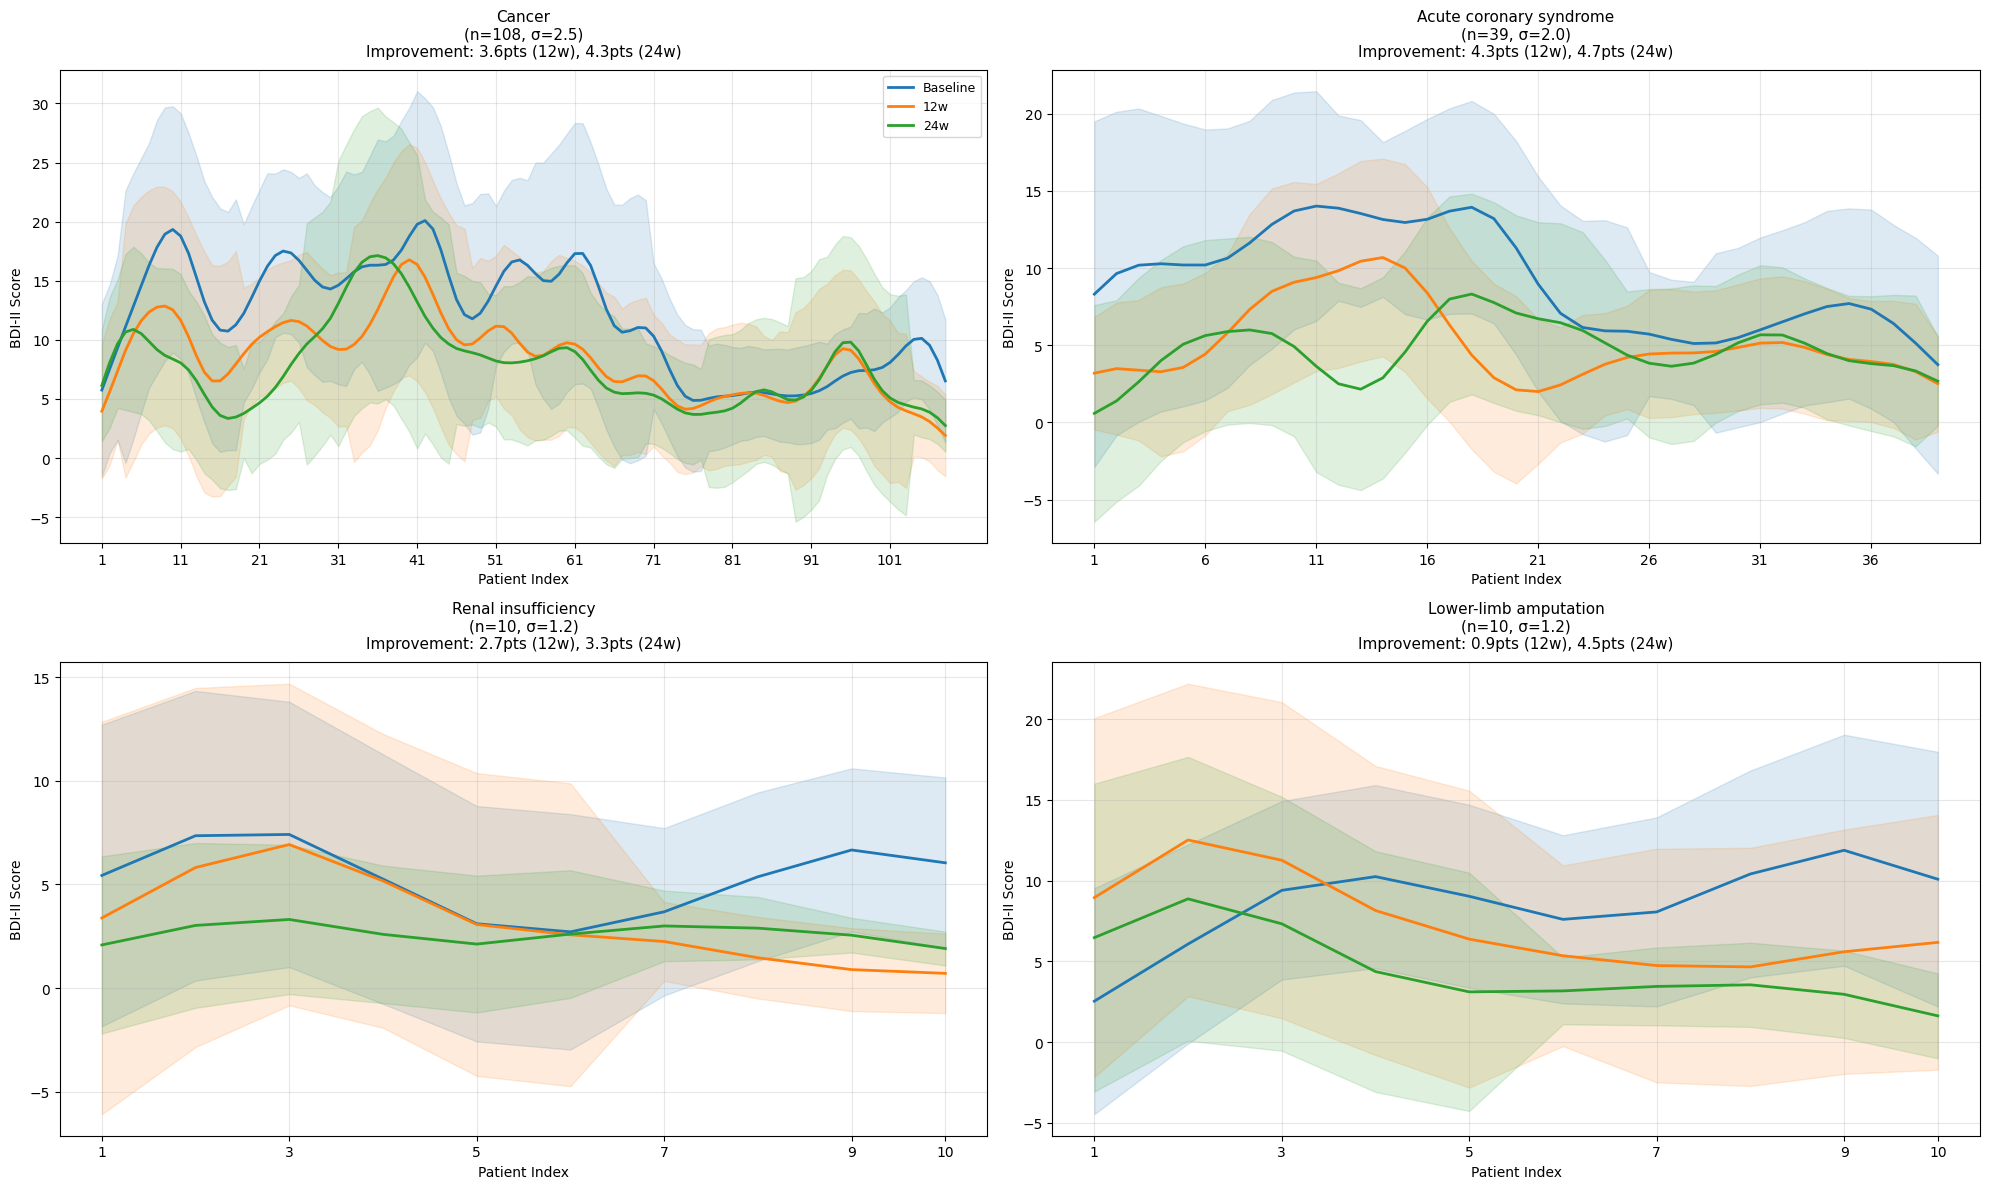

Multi-panel view completed for 4 conditions.


In [18]:
# Alternative: Create a combined multi-panel view of all conditions
print("\n" + "="*80)
print("COMBINED MULTI-PANEL VIEW: ALL CONDITIONS")
print("="*80)

# Calculate the optimal subplot layout
n_conditions = len(conditions_to_analyze)
n_cols = 2  # 2 columns for better readability
n_rows = (n_conditions + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

# Flatten axes for easier indexing
if n_rows > 1:
    axes = axes.flatten()
elif n_cols == 1:
    axes = [axes]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, condition in enumerate(conditions_to_analyze):
    ax = axes[i]
    
    # Filter data for this condition
    condition_data = df_complete[df_complete['condition'] == condition].copy()
    condition_sorted = condition_data.copy().reset_index(drop=True)
    
    # Create patient_id if it doesn't exist
    if 'patient_id' not in condition_sorted.columns:
        condition_sorted['patient_id'] = np.arange(1, len(condition_sorted) + 1)
    
    # Sort by patient_id
    condition_sorted = condition_sorted.sort_values('patient_id').reset_index(drop=True)
    
    # Extract BDI scores
    y_baseline = condition_sorted['bdi_ii_baseline'].astype(float).to_numpy()
    y_12w = condition_sorted['bdi_ii_after_intervention_12w'].astype(float).to_numpy()
    y_24w = condition_sorted['bdi_ii_follow_up_24w'].astype(float).to_numpy()
    
    # Filter valid patients
    valid_patients = ~(np.isnan(y_baseline) & np.isnan(y_12w) & np.isnan(y_24w))
    
    if valid_patients.any():
        y_baseline_filtered = y_baseline[valid_patients]
        y_12w_filtered = y_12w[valid_patients]
        y_24w_filtered = y_24w[valid_patients]
        
        x = np.arange(1, len(y_baseline_filtered) + 1)
        n_patients = len(y_baseline_filtered)
        
        # Interpolate missing values for smoother visualization
        def interpolate_missing(arr):
            """Interpolate missing values for smoother visualization"""
            arr_interp = arr.copy()
            valid_mask = ~np.isnan(arr_interp)
            if valid_mask.sum() > 1:  # Need at least 2 valid points
                indices = np.arange(len(arr_interp))
                arr_interp[~valid_mask] = np.interp(indices[~valid_mask], indices[valid_mask], arr_interp[valid_mask])
            return arr_interp
        
        y_baseline_interp = interpolate_missing(y_baseline_filtered)
        y_12w_interp = interpolate_missing(y_12w_filtered)
        y_24w_interp = interpolate_missing(y_24w_filtered)
        
        # Adjust sigma based on sample size
        if n_patients < 20:
            adjusted_sigma = max(1.0, 2.5 * 0.5)
        elif n_patients < 50:
            adjusted_sigma = 2.5 * 0.8
        else:
            adjusted_sigma = 2.5
        
        # Create kernel and smooth
        kernel = gaussian_kernel(adjusted_sigma)
        window = len(kernel)
        
        yb_s, lb, ub = smooth_and_band(y_baseline_interp, kernel, window)
        y12_s, l12, u12 = smooth_and_band(y_12w_interp, kernel, window)
        y24_s, l24, u24 = smooth_and_band(y_24w_interp, kernel, window)
        
        # Plot
        ax.plot(x, yb_s, color=colors[0], label='Baseline', linewidth=2)
        ax.fill_between(x, lb, ub, color=colors[0], alpha=0.15)
        
        ax.plot(x, y12_s, color=colors[1], label='12w', linewidth=2)
        ax.fill_between(x, l12, u12, color=colors[1], alpha=0.15)
        
        ax.plot(x, y24_s, color=colors[2], label='24w', linewidth=2)
        ax.fill_between(x, l24, u24, color=colors[2], alpha=0.15)
        
        # Calculate improvements
        baseline_mean = np.nanmean(y_baseline_filtered)
        w12_mean = np.nanmean(y_12w_filtered)
        w24_mean = np.nanmean(y_24w_filtered)
        improvement_12w = baseline_mean - w12_mean
        improvement_24w = baseline_mean - w24_mean
        
        ax.set_title(f'{condition}\n(n={n_patients}, σ={adjusted_sigma:.1f})\nImprovement: {improvement_12w:.1f}pts (12w), {improvement_24w:.1f}pts (24w)', 
                    fontsize=11, pad=10)
        ax.set_xlabel('Patient Index', fontsize=10)
        ax.set_ylabel('BDI-II Score', fontsize=10)
        
        # Adjust ticks
        if n_patients <= 20:
            step = max(2, n_patients // 5)
        else:
            step = max(5, n_patients // 10)
        
        xticks = list(range(1, int(x.max()) + 1, step))
        if int(x.max()) not in xticks and len(xticks) < 8:
            xticks.append(int(x.max()))
        ax.set_xticks(xticks)
        
        if i == 0:  # Only show legend on first plot
            ax.legend(loc='upper right', fontsize=9)
        
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No valid data\nfor {condition}', 
               transform=ax.transAxes, ha='center', va='center')
        ax.set_title(condition, fontsize=11)

# Hide empty subplots
for j in range(n_conditions, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Multi-panel view completed for {n_conditions} conditions.")